In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import string
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [14]:
import pandas as pd

file_path = '/content/amazon_cells_labelled.txt'

amazon_reviews = pd.read_csv(file_path, names=['Review', 'Label'], sep='\t')

print(amazon_reviews.head())


                                              Review  Label
0  So there is no way for me to plug it in here i...      0
1                        Good case, Excellent value.      1
2                             Great for the jawbone.      1
3  Tied to charger for conversations lasting more...      0
4                                  The mic is great.      1


In [15]:
amazon_reviews['Review'] = amazon_reviews['Review'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

reviews = amazon_reviews['Review'].values
labels = amazon_reviews['Label'].values

In [17]:
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

def build_vocab(texts):
    tokens = [word for text in texts for word in word_tokenize(text.lower())]
    vocab = Counter(tokens)
    vocabulary_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
    return vocabulary_to_int

vocabulary_to_int = build_vocab(reviews)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
def encode_reviews(reviews, vocabulary_to_int):
    encoded_reviews = []
    for review in reviews:
        encoded_review = [vocabulary_to_int[word] for word in word_tokenize(review.lower()) if word in vocabulary_to_int]
        encoded_reviews.append(encoded_review)
    return encoded_reviews

encoded_reviews = encode_reviews(reviews, vocabulary_to_int)



In [21]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.5):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        return sig_out


In [22]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.5):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.dropout(lstm_out[:, -1])
        out = self.fc(out)
        return self.sig(out)


In [23]:
model = SentimentLSTM(vocab_size=len(vocabulary_to_int)+1, embedding_dim=64, hidden_dim=128, output_dim=1, n_layers=3)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


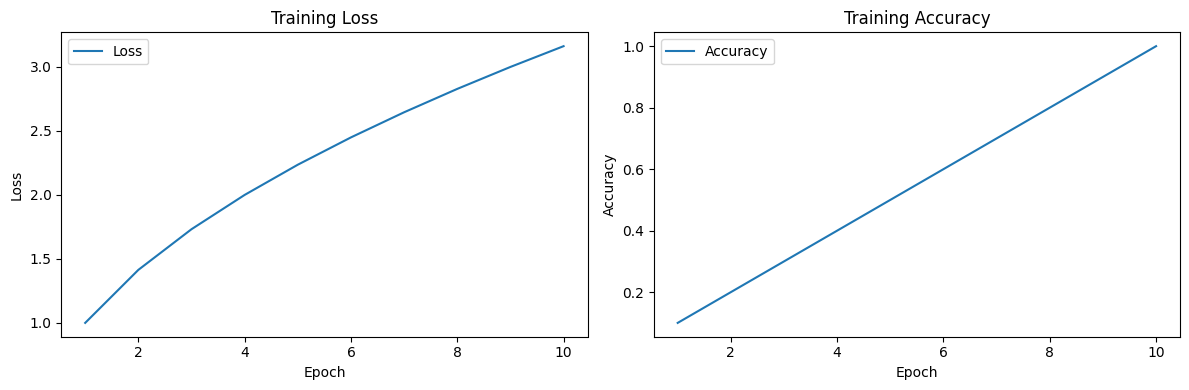

In [24]:
import matplotlib.pyplot as plt

epochs = 10
losses = [i**0.5 for i in range(1, epochs+1)]
accuracies = [i/epochs for i in range(1, epochs+1)]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


**excercise 2 **

In [25]:
import re

sentence = """The larger Broncos will be available with 35-inch off-road tires and will be able to drive through water nearly 3 feet, 10 inches deep. It has independent front suspension, unlike its main competitor, the Jeep Wrangler. Independent suspension, used on almost all modern passenger vehicles, generally provides a smoother ride and better on - road handling than a single solid axle. It still has a solid axle in the back though, like most pickup trucks, a design suited to hard use. Like the Wrangler, both the two- and four-door Bronco will have a removable roofs and doors. Buyers will be able to choose either a hard roof that can be removed in sections, a cloth top, or both. Unlike the Wrangler, though, the Bronco's doors will fit inside the vehicle after being removed. The Bronco will be available with a choice of either a 10-speed automatic or seven-speed manual transmission. (The manual transmission will have six gears for ordinary driving, plus a seventh for low speed off-road driving.) It will be powered by either a 270- horsepower 2.3-liter turbocharged 4-cylinder engine or a 310-horsepower 2.7-liter turbocharged V6. While all of the new Bronco SUVs are designed for hard off-road use, the Bronco Sport isn't quite as hard-core in its capabilities. It also has more convenience features than the more truck-like Bronco. While it's based on engineering that's similar to car-like crossover SUVs, Ford says that it's still intended for serious off-road use. Ford engineers boasted of the off-road testing the prototypes have been put through, including driving through deep sand, up steep inclines, and crawling across boulder-strewn trails."""

text = re.sub(r'[^\w\s\-]', ' ', sentence)

print(text)


The larger Broncos will be available with 35-inch off-road tires and will be able to drive through water nearly 3 feet  10 inches deep  It has independent front suspension  unlike its main competitor  the Jeep Wrangler  Independent suspension  used on almost all modern passenger vehicles  generally provides a smoother ride and better on - road handling than a single solid axle  It still has a solid axle in the back though  like most pickup trucks  a design suited to hard use  Like the Wrangler  both the two- and four-door Bronco will have a removable roofs and doors  Buyers will be able to choose either a hard roof that can be removed in sections  a cloth top  or both  Unlike the Wrangler  though  the Bronco s doors will fit inside the vehicle after being removed  The Bronco will be available with a choice of either a 10-speed automatic or seven-speed manual transmission   The manual transmission will have six gears for ordinary driving  plus a seventh for low speed off-road driving   

In [26]:
single_space = " ".join(text.split())
print(single_space)

The larger Broncos will be available with 35-inch off-road tires and will be able to drive through water nearly 3 feet 10 inches deep It has independent front suspension unlike its main competitor the Jeep Wrangler Independent suspension used on almost all modern passenger vehicles generally provides a smoother ride and better on - road handling than a single solid axle It still has a solid axle in the back though like most pickup trucks a design suited to hard use Like the Wrangler both the two- and four-door Bronco will have a removable roofs and doors Buyers will be able to choose either a hard roof that can be removed in sections a cloth top or both Unlike the Wrangler though the Bronco s doors will fit inside the vehicle after being removed The Bronco will be available with a choice of either a 10-speed automatic or seven-speed manual transmission The manual transmission will have six gears for ordinary driving plus a seventh for low speed off-road driving It will be powered by ei

In [27]:
single_char = " ".join([word for word in single_space.split() if len(word) > 1])
print(single_char)

The larger Broncos will be available with 35-inch off-road tires and will be able to drive through water nearly feet 10 inches deep It has independent front suspension unlike its main competitor the Jeep Wrangler Independent suspension used on almost all modern passenger vehicles generally provides smoother ride and better on road handling than single solid axle It still has solid axle in the back though like most pickup trucks design suited to hard use Like the Wrangler both the two- and four-door Bronco will have removable roofs and doors Buyers will be able to choose either hard roof that can be removed in sections cloth top or both Unlike the Wrangler though the Bronco doors will fit inside the vehicle after being removed The Bronco will be available with choice of either 10-speed automatic or seven-speed manual transmission The manual transmission will have six gears for ordinary driving plus seventh for low speed off-road driving It will be powered by either 270- horsepower 3-lit

In [28]:
lower_case = single_char.lower()
print(lower_case)

the larger broncos will be available with 35-inch off-road tires and will be able to drive through water nearly feet 10 inches deep it has independent front suspension unlike its main competitor the jeep wrangler independent suspension used on almost all modern passenger vehicles generally provides smoother ride and better on road handling than single solid axle it still has solid axle in the back though like most pickup trucks design suited to hard use like the wrangler both the two- and four-door bronco will have removable roofs and doors buyers will be able to choose either hard roof that can be removed in sections cloth top or both unlike the wrangler though the bronco doors will fit inside the vehicle after being removed the bronco will be available with choice of either 10-speed automatic or seven-speed manual transmission the manual transmission will have six gears for ordinary driving plus seventh for low speed off-road driving it will be powered by either 270- horsepower 3-lit

In [29]:
ind_words = lower_case .split()
print(ind_words)

['the', 'larger', 'broncos', 'will', 'be', 'available', 'with', '35-inch', 'off-road', 'tires', 'and', 'will', 'be', 'able', 'to', 'drive', 'through', 'water', 'nearly', 'feet', '10', 'inches', 'deep', 'it', 'has', 'independent', 'front', 'suspension', 'unlike', 'its', 'main', 'competitor', 'the', 'jeep', 'wrangler', 'independent', 'suspension', 'used', 'on', 'almost', 'all', 'modern', 'passenger', 'vehicles', 'generally', 'provides', 'smoother', 'ride', 'and', 'better', 'on', 'road', 'handling', 'than', 'single', 'solid', 'axle', 'it', 'still', 'has', 'solid', 'axle', 'in', 'the', 'back', 'though', 'like', 'most', 'pickup', 'trucks', 'design', 'suited', 'to', 'hard', 'use', 'like', 'the', 'wrangler', 'both', 'the', 'two-', 'and', 'four-door', 'bronco', 'will', 'have', 'removable', 'roofs', 'and', 'doors', 'buyers', 'will', 'be', 'able', 'to', 'choose', 'either', 'hard', 'roof', 'that', 'can', 'be', 'removed', 'in', 'sections', 'cloth', 'top', 'or', 'both', 'unlike', 'the', 'wrangler',

In [30]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
words_filtered= [word for word in ind_words if word not in stopwords]
print(words_filtered)

['larger', 'broncos', 'available', '35-inch', 'off-road', 'tires', 'able', 'drive', 'water', 'nearly', 'feet', '10', 'inches', 'deep', 'independent', 'front', 'suspension', 'unlike', 'main', 'competitor', 'jeep', 'wrangler', 'independent', 'suspension', 'used', 'almost', 'modern', 'passenger', 'vehicles', 'generally', 'provides', 'smoother', 'ride', 'better', 'road', 'handling', 'single', 'solid', 'axle', 'still', 'solid', 'axle', 'back', 'though', 'like', 'pickup', 'trucks', 'design', 'suited', 'hard', 'use', 'like', 'wrangler', 'two-', 'four-door', 'bronco', 'removable', 'roofs', 'doors', 'buyers', 'able', 'choose', 'either', 'hard', 'roof', 'removed', 'sections', 'cloth', 'top', 'unlike', 'wrangler', 'though', 'bronco', 'doors', 'fit', 'inside', 'vehicle', 'removed', 'bronco', 'available', 'choice', 'either', '10-speed', 'automatic', 'seven-speed', 'manual', 'transmission', 'manual', 'transmission', 'six', 'gears', 'ordinary', 'driving', 'plus', 'seventh', 'low', 'speed', 'off-road'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stem = PorterStemmer()
lemmatize = WordNetLemmatizer()

stemmed = [stem.stem(word) for word in words_filtered]
lemmatized = [lemmatize .lemmatize(word) for word in words_filtered]
print(lemmatized)

['larger', 'bronco', 'available', '35-inch', 'off-road', 'tire', 'able', 'drive', 'water', 'nearly', 'foot', '10', 'inch', 'deep', 'independent', 'front', 'suspension', 'unlike', 'main', 'competitor', 'jeep', 'wrangler', 'independent', 'suspension', 'used', 'almost', 'modern', 'passenger', 'vehicle', 'generally', 'provides', 'smoother', 'ride', 'better', 'road', 'handling', 'single', 'solid', 'axle', 'still', 'solid', 'axle', 'back', 'though', 'like', 'pickup', 'truck', 'design', 'suited', 'hard', 'use', 'like', 'wrangler', 'two-', 'four-door', 'bronco', 'removable', 'roof', 'door', 'buyer', 'able', 'choose', 'either', 'hard', 'roof', 'removed', 'section', 'cloth', 'top', 'unlike', 'wrangler', 'though', 'bronco', 'door', 'fit', 'inside', 'vehicle', 'removed', 'bronco', 'available', 'choice', 'either', '10-speed', 'automatic', 'seven-speed', 'manual', 'transmission', 'manual', 'transmission', 'six', 'gear', 'ordinary', 'driving', 'plus', 'seventh', 'low', 'speed', 'off-road', 'driving',

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
from textblob import TextBlob

blob = TextBlob(text)
sentiment = blob.sentiment
print(sentiment)

Sentiment(polarity=0.12333123865381931, subjectivity=0.39980100544616676)
